In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms

In [6]:
transform = transforms.Compose([
    transforms.ToTensor()
])
mnist_dataset = datasets.MNIST(root='data/', download=True, transform=transform, train=True)
train_set = mnist_dataset
train_set, validation_set = torch.utils.data.random_split(train_set,[50000,10000])
mnist_dataset = datasets.MNIST(root='data/', download=True, transform=transform, train=False)
test_set = mnist_dataset

In [7]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.encoder_nn = nn.Sequential(
        nn.Conv2d(1, 64, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2, stride=2, padding=1),
        nn.Conv2d(64, 128, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Dropout2d(0.2),
        nn.MaxPool2d(2, stride=2),
        nn.Conv2d(128, 256, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.Dropout2d(0.2),
        nn.MaxPool2d(2, stride=2),
        nn.Conv2d(256, 512, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(512),
        nn.Dropout2d(0.2),
        nn.MaxPool2d(2, stride=2)
    )

    self.decoder_nn = nn.Sequential(
        nn.ConvTranspose2d(512, 256, 4, stride=2),
        nn.ReLU(),
        nn.Conv2d(256, 256, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.ConvTranspose2d(256, 128, 4, stride=2),
        nn.ReLU(),
        nn.Conv2d(128, 128, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.ConvTranspose2d(128, 64, 4, stride=2),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.ConvTranspose2d(64, 32, 4, stride=2),
        nn.ReLU(),
        nn.Conv2d(32, 32, 3, stride=3),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.ConvTranspose2d(32, 1, 4, stride=2),
        nn.ReLU(),
        nn.Conv2d(1, 1, 3),
        nn.ReLU()
      )

  def forward(self, image):
    encoded_image = self.encoder_nn(image)
    decoded_image = self.decoder_nn(encoded_image)
    return decoded_image.squeeze(1)

In [44]:
class Generator(nn.Module):
  def __init__(self, encoder):
    super().__init__()
    self.encoder_nn = encoder

    self.rand_vector_nn = nn.Sequential(
        nn.Linear(100, 512),
        nn.LeakyReLU(0.2),
        nn.Linear(512, 512),
        nn.LeakyReLU(0.2)
    )

    self.generator_nn = nn.Sequential(
        nn.BatchNorm2d(1024),
        nn.ConvTranspose2d(1024, 512, 4, stride=2),
        nn.LeakyReLU(0.2),
        nn.Conv2d(512, 512, 3, padding=(1,0)),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(512),
        nn.ConvTranspose2d(512, 256, 4, stride=2),
        nn.LeakyReLU(0.2),
        nn.Conv2d(256, 256, 3),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(256),
        nn.ConvTranspose2d(256, 128, 4, stride=2),
        nn.LeakyReLU(0.2),
        nn.Conv2d(128, 128, 3),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(128),
        nn.ConvTranspose2d(128, 64, 4, stride=2),
        nn.LeakyReLU(0.2),
        nn.Conv2d(64, 64, 3, stride=3, padding=(3,0)),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(64),
        nn.ConvTranspose2d(64, 1, 4, stride=2),
        nn.LeakyReLU(0.2)
    )

  def forward(self, left_side, rand_vector):
    with torch.no_grad():
      image_features = self.encoder_nn(left_side).reshape(-1, 512, 1, 1)
    noise_features = self.rand_vector_nn(rand_vector).reshape(-1, 512, 1, 1)
    reconstruction = self.generator_nn(torch.cat((image_features, noise_features), dim=1)).clamp(0,1)
    return reconstruction.squeeze(1)

In [51]:
class Discriminator(nn.Module):
  def __init__(self, encoder):
    super().__init__()
    self.encoder_nn = encoder

    self.fc_nn = nn.Sequential(
       nn.Flatten(),
       nn.Linear(512, 1024),
       nn.ReLU(),
       nn.Dropout(p=0.2),
       nn.Linear(1024, 512),
       nn.ReLU(),
       nn.Dropout(p=0.2),
       nn.Linear(512, 256),
       nn.ReLU(),
       nn.Dropout(p=0.2),
       nn.Linear(256, 1),
       nn.Sigmoid()
    )

  def forward(self, image):
    encoded_image = self.encoder_nn(image)
    result = self.fc_nn(encoded_image) 
    return result.squeeze(1)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
encoder = Encoder().to(device)
encoder_optim = torch.optim.Adam(encoder.parameters())
criterion = nn.MSELoss()

In [12]:
num_epochs = 40
batch_size = 40

train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=False)

In [13]:
num_iters_train = len(train_loader)
num_iters_validation = len(validation_loader)

train_losses = np.zeros((num_epochs, num_iters_train))
validation_losses = np.zeros((num_epochs, num_iters_validation))

for epoch in range(num_epochs):
  for iter, (image, labels) in enumerate(train_loader):
    image, labels = image.to(device), labels.to(device)
    outputs = encoder(image)

    loss = criterion(outputs, image.squeeze())
    train_losses[epoch, iter] = loss

    encoder_optim.zero_grad()
    loss.backward()
    encoder_optim.step()

  print('Training epoch number', epoch + 1, '-->   Loss :', train_losses[epoch].sum() / len(train_loader))

  for iter, (image, labels) in enumerate(validation_loader):
    image, labels = image.to(device), labels.to(device)
    outputs = encoder(image)

    loss = criterion(outputs, image.squeeze())
    validation_losses[epoch, iter] = loss

  torch.save(encoder.state_dict(), 'drive/MyDrive/Colab Notebooks/encoder.pkl')
  print('Validation epoch number', epoch + 1, '-->   Loss :', validation_losses[epoch].sum() / len(validation_loader))

In [14]:
criterion = nn.MSELoss()
with torch.no_grad():
  total_loss = 0
  encoder.eval()
  for iter, (image, labels) in enumerate(test_loader):
    image, labels = image.to(device), labels.to(device)
    outputs = encoder(image)
    total_loss += criterion(outputs, image.squeeze())
  
print('Total loss on the test set is:', float(total_loss / len(test_loader)))

In [15]:
checkpoint_encoder = torch.load('drive/MyDrive/Colab Notebooks/encoder.pkl', map_location=torch.device('cuda'))
encoder.load_state_dict(checkpoint_encoder)

<All keys matched successfully>

In [55]:
generator = Generator(encoder.encoder_nn).to(device)
discriminator = Discriminator(encoder.encoder_nn).to(device)

generator_optim = torch.optim.Adam(generator.generator_nn.parameters(), lr=1e-6)
discriminator_optim = torch.optim.Adam(discriminator.parameters(), lr=1e-6)

criterion = nn.BCELoss()

batch_size = 200
num_epochs = 20
train_set = datasets.MNIST(root='data/', download=True, transform=transform, train=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)

In [56]:
gen_train_losses = np.zeros(num_epochs)
disc_train_losses = np.zeros(num_epochs)

In [57]:
for epoch in range(num_epochs):
  generator_loss = 0
  discriminator_loss = 0
  a, b = 0, 0

  for iter, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    if (iter + 1) % 5 != 0:
      a += 1
      generated_images = generator(images[..., :14], torch.randn((batch_size, 100)).to(device))
      predictions = discriminator(torch.cat((images[..., :14], generated_images.unsqueeze(1)), dim=-1))

      loss = criterion((torch.zeros(batch_size) + 1e-3).unsqueeze(0).to(device), predictions.unsqueeze(0))
      generator_loss += float(loss)

      generator_optim.zero_grad()
      loss.backward()
      generator_optim.step()
      
    else:
      b += 1
      real_images = images[:batch_size // 2]
      other_images = images[batch_size // 2:]

      with torch.no_grad():
        generated_images = generator(other_images[..., :14], torch.randn((batch_size // 2, 100)).to(device)).detach()

      generated_images = torch.cat((other_images[..., :14], generated_images.unsqueeze(1)), dim=-1)
      discriminator_preds = discriminator(torch.cat((real_images, generated_images), dim=0))
      loss = criterion(torch.cat(((torch.zeros(batch_size // 2) + 1e-3).unsqueeze(0).to(device), 
                                  (torch.ones(batch_size // 2) - 1e-3).unsqueeze(0).to(device)), dim=-1), 
                                  discriminator_preds.unsqueeze(0))
      discriminator_loss += float(loss)
      
      discriminator_optim.zero_grad()
      loss.backward()
      discriminator_optim.step()

  gen_train_losses[epoch] = generator_loss / a
  disc_train_losses[epoch] = discriminator_loss / b
  print('Loss in epoch number', epoch + 1, '--> Generator:', gen_train_losses[epoch], 'Discriminator:', disc_train_losses[epoch])


Loss in epoch number 1 --> Generator: 3.4264802167812984 Discriminator: 3.452346408367157
Loss in epoch number 2 --> Generator: 3.440497147043546 Discriminator: 3.439203997453054
Loss in epoch number 3 --> Generator: 3.455983629822731 Discriminator: 3.425529897212982
Loss in epoch number 4 --> Generator: 3.471534221371015 Discriminator: 3.411368735631307
Loss in epoch number 5 --> Generator: 3.485286441445351 Discriminator: 3.3986369609832763
Loss in epoch number 6 --> Generator: 3.4933023790518445 Discriminator: 3.3878602464993794
Loss in epoch number 7 --> Generator: 3.4816998730103177 Discriminator: 3.387166889508565
Loss in epoch number 8 --> Generator: 3.43582255144914 Discriminator: 3.40559800863266
Loss in epoch number 9 --> Generator: 3.400860484441121 Discriminator: 3.4218395590782165
Loss in epoch number 10 --> Generator: 3.399695826570193 Discriminator: 3.423972749710083
Loss in epoch number 11 --> Generator: 3.4055262058973312 Discriminator: 3.4204452991485597
Loss in epoch

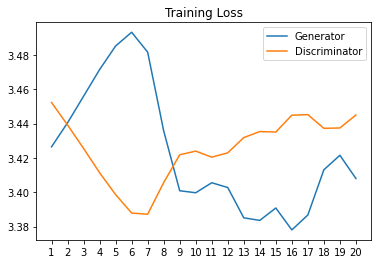

<Figure size 432x288 with 0 Axes>

In [58]:
x_label = np.arange(1, num_epochs + 1)
plt.plot(x_label, gen_train_losses[:num_epochs])
plt.plot(x_label, disc_train_losses[:num_epochs])
plt.xticks(x_label)
plt.title("Training Loss")
plt.legend(['Generator', 'Discriminator'])
plt.figure()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


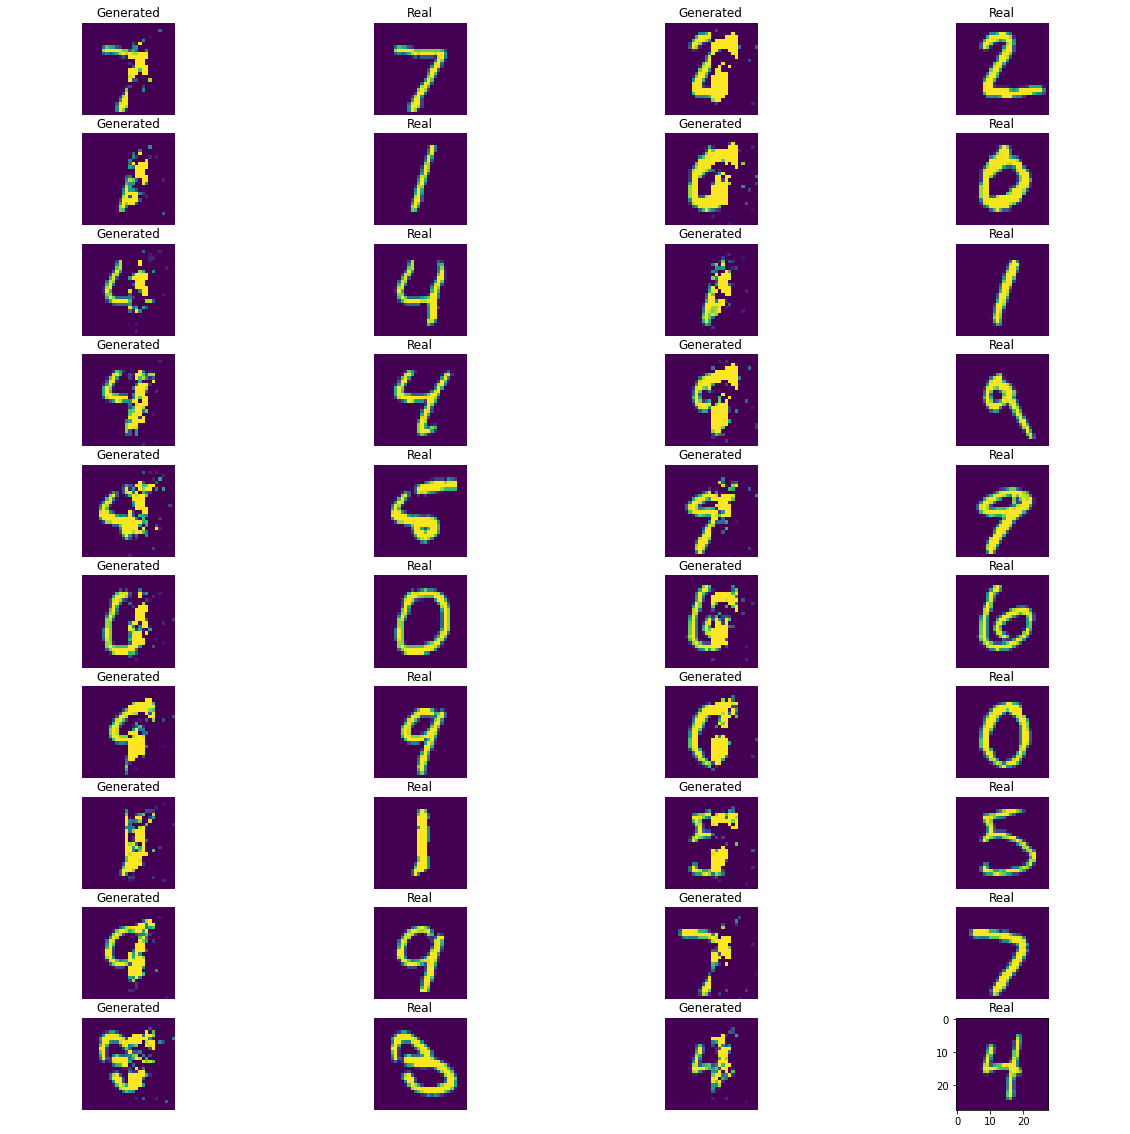

In [59]:
test = np.array(test_set)[0:20, 0].tolist()
images = torch.tensor([])
for image in test:
  images = torch.cat((images, image))

with torch.no_grad():
  generator.eval()
  generated_images = generator(images.reshape(20,1,28,28).to(device), torch.randn((20, 100)).to(device))
  generated_images = torch.cat((images[..., :14].to(device), generated_images.to(device)), dim=-1)

fig = plt.figure(figsize=(20, 20))
for i in range(20):
  plt.axis('off')
  fig.add_subplot(10, 4, 2 * i + 1)
  plt.title('Generated')
  plt.imshow(generated_images[i].cpu().squeeze())
  plt.axis('off')
  fig.add_subplot(10, 4, 2 * i + 2)
  plt.title('Real')
  plt.imshow(images[i])